<a href="https://colab.research.google.com/github/dimageneer/AIEFFEL_QUEST/blob/main/Day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 베이즈 통계

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.manifold import TSNE

In [ ]:
# 1. 데이터 생성 (실제 임상시험 데이터라고 가정)
np.random.seed(42)
# 신약 투여 집단 데이터 (평균 130, 표준편차 10)
drug_group_bp = np.random.normal(130, 10, 20)
# 위약 투여 집단 데이터 (평균 140, 표준편차 12)
placebo_group_bp = np.random.normal(140, 12, 20)

In [ ]:
print("신약 투여 집단 평균 혈압:", np.mean(drug_group_bp))
print("위약 투여 집단 평균 혈압:", np.mean(placebo_group_bp))
print("-" * 30)

신약 투여 집단 평균 혈압: 128.2870143855817
위약 투여 집단 평균 혈압: 136.80829861527138
------------------------------


In [ ]:
# 2. 베이즈 모델 정의
with pm.Model() as blood_pressure_model:
    # 각 집단의 평균(mu)에 대한 사전 분포(prior)
    # 혈압 데이터의 전체 평균과 표준편차를 기반으로 약한 정보의 사전 분포 설정
    mu_drug = pm.Normal('mu_drug', mu=135, sigma=20)
    mu_placebo = pm.Normal('mu_placebo', mu=135, sigma=20)

    # 각 집단의 표준편차(sigma)에 대한 사전 분포
    # 표준편차는 0보다 커야 하므로 HalfNormal 분포 사용
    sigma_drug = pm.HalfNormal('sigma_drug', sigma=20)
    sigma_placebo = pm.HalfNormal('sigma_placebo', sigma=20)

    # 데이터의 가능도(likelihood) 정의
    # 데이터가 정규분포를 따른다고 가정
    drug_likelihood = pm.Normal('drug_likelihood', mu=mu_drug, sigma=sigma_drug, observed=drug_group_bp)
    placebo_likelihood = pm.Normal('placebo_likelihood', mu=mu_placebo, sigma=sigma_placebo, observed=placebo_group_bp)

    # 두 집단 간 평균 혈압 차이를 계산하는 결정론적 변수(deterministic variable)
    mean_difference = pm.Deterministic('mean_difference', mu_drug - mu_placebo)

In [ ]:
with blood_pressure_model:
    # MCMC 샘플링 실행
    trace = pm.sample(2000, tune=1000, cores=1)

Output()

In [ ]:
summary = az.summary(trace, var_names=['mean_difference'])
print(summary)

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mean_difference -8.333  3.599 -15.325   -1.646      0.057    0.055    4005.0   

                 ess_tail  r_hat  
mean_difference    3049.0    1.0  


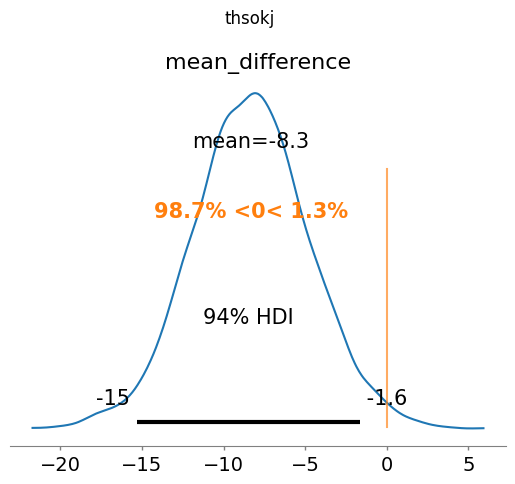

In [ ]:
az.plot_posterior(trace, var_names=['mean_difference'], ref_val=0)
plt.suptitle("thsokj", y=1.02)
plt.show()

In [ ]:
posterior_diff = trace.posterior['mean_difference'].values.flatten()
prob_effect = np.mean(posterior_diff < 0)

print(f"\n신약이 위약보다 혈압을 낮출 확률: {prob_effect:.2%}")


신약이 위약보다 혈압을 낮출 확률: 98.72%


## 주성분 분석과 t-SNE를 통한 차원축소

In [ ]:
from sklearn import datasets

digits = datasets.load_digits()

In [ ]:
X = digits.data
y = digits.target

print(X.shape)

(1797, 64)


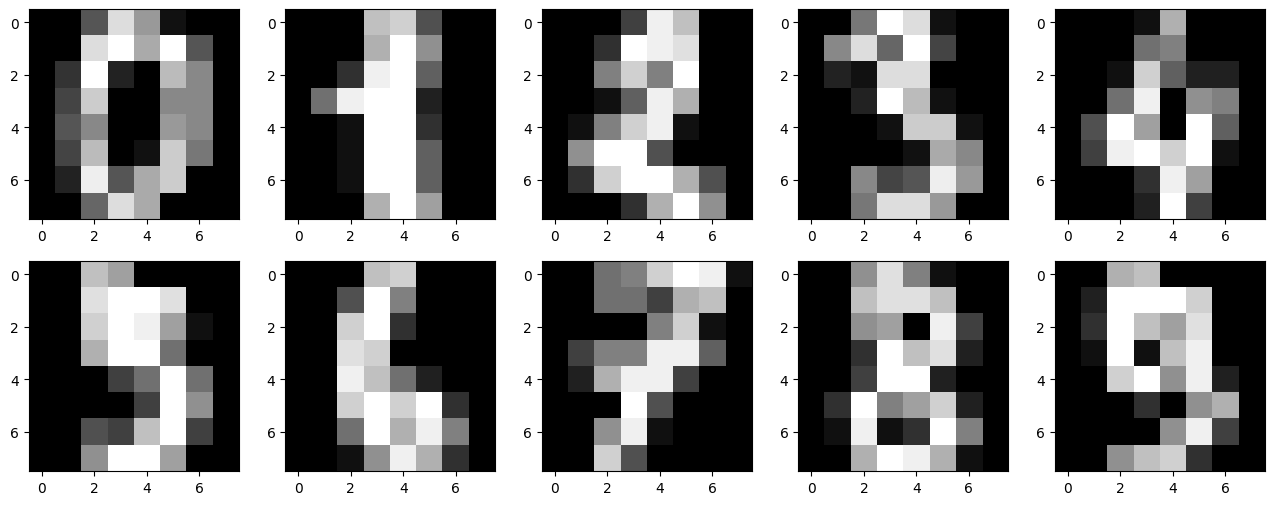

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Projecting 64-dimensional data to 2D


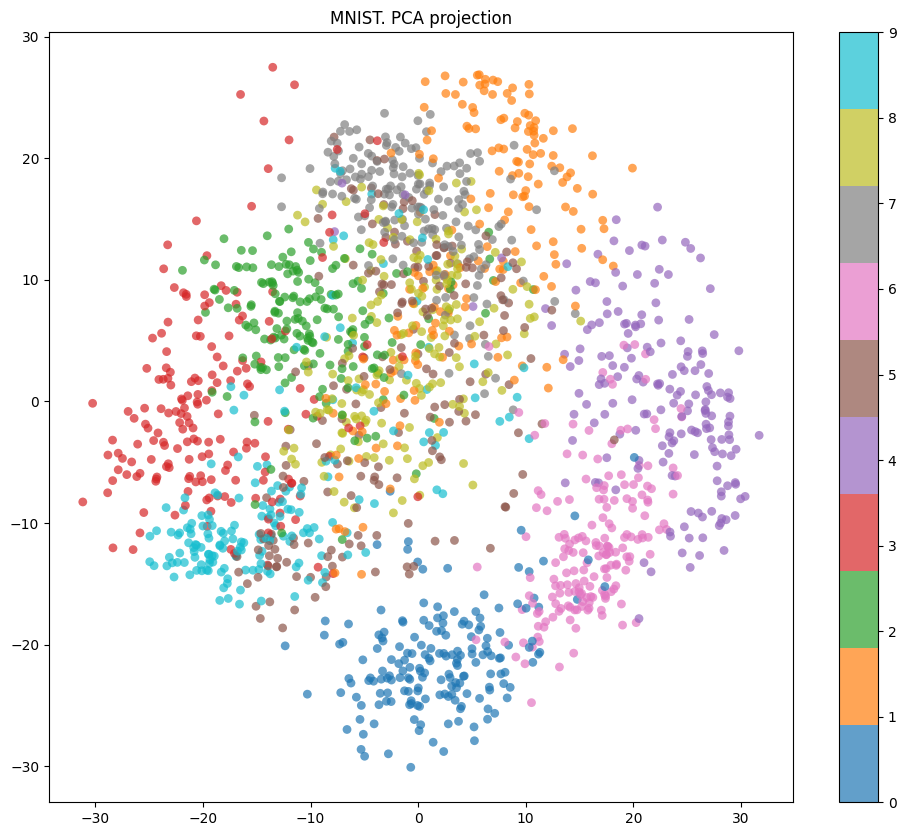

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import colormaps

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=colormaps.get_cmap('tab10'))
plt.colorbar()
plt.title('MNIST. PCA projection')
plt.show()

Text(0.5, 1.0, 'MNIST. t-SNE projection')

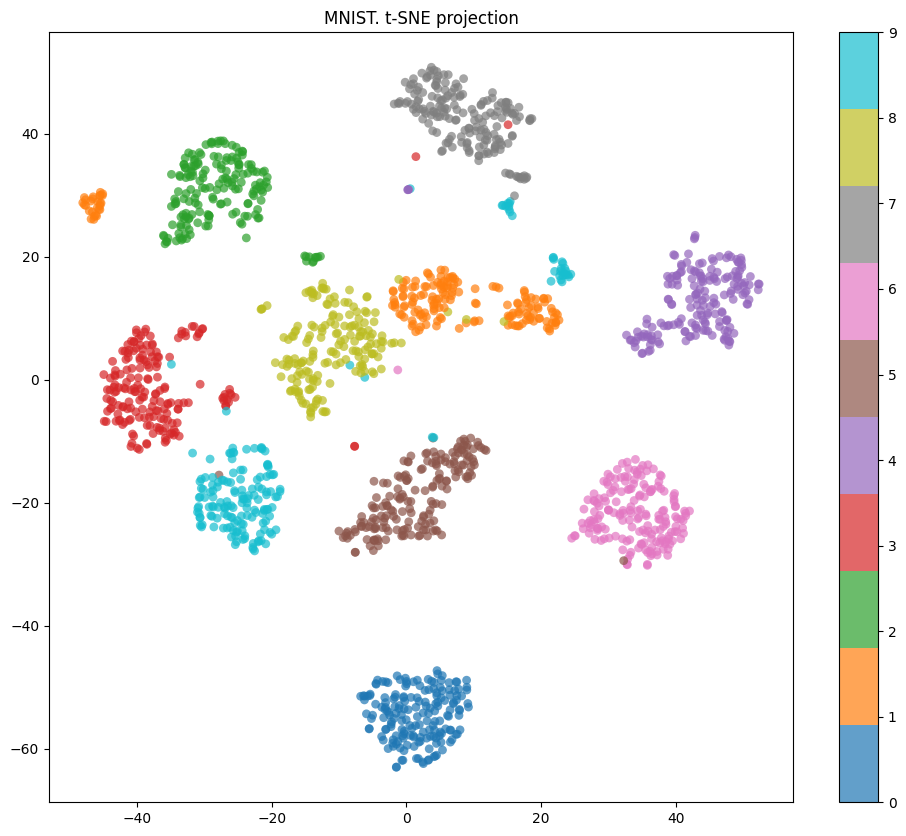

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=colormaps.get_cmap('tab10'))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Wine 데이터셋 로드
wine = datasets.load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# PCA 진행
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

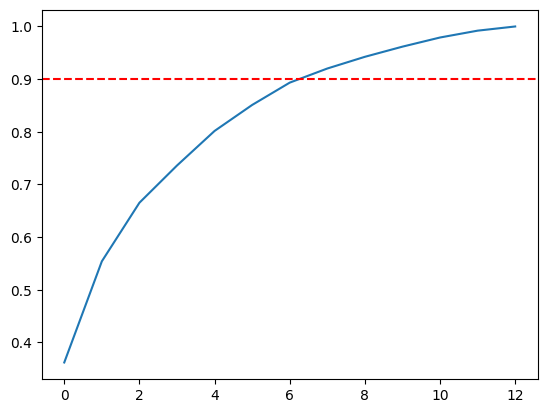

In [ ]:
# 누적 기여율 그래프
explained_variance = pca.explained_variance_ratio_

cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(len(cumsum)), cumsum)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.show()

In [ ]:
explained_variance_df = pd.DataFrame({'기여율': explained_variance,
                                      '누적기여율': cumsum})
explained_variance_df

,기여율,누적기여율
0,0.361988,0.361988
1,0.192075,0.554063
2,0.111236,0.665300
3,0.070690,0.735990
4,0.065633,0.801623
5,0.049358,0.850981
6,0.042387,0.893368
7,0.026807,0.920175
8,0.022222,0.942397
9,0.019300,0.961697


In [ ]:
print("### 주성분 분석 결과 ###\n")
print(f"주성분 1 (PC1)의 설명 분산: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"주성분 2 (PC2)의 설명 분산: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"주성분 3 (PC3)의 설명 분산: {explained_variance[2]:.4f} ({explained_variance[2]*100:.2f}%)")
print(f"여섯번째 주성분까지 설명하는 총 분산: {np.sum(explained_variance[:7]):.4f} ({np.sum(explained_variance[:7])*100:.2f}%)")

### 주성분 분석 결과 ###

주성분 1 (PC1)의 설명 분산: 0.3620 (36.20%)
주성분 2 (PC2)의 설명 분산: 0.1921 (19.21%)
주성분 3 (PC3)의 설명 분산: 0.1112 (11.12%)
여섯번째 주성분까지 설명하는 총 분산: 0.8934 (89.34%)


In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

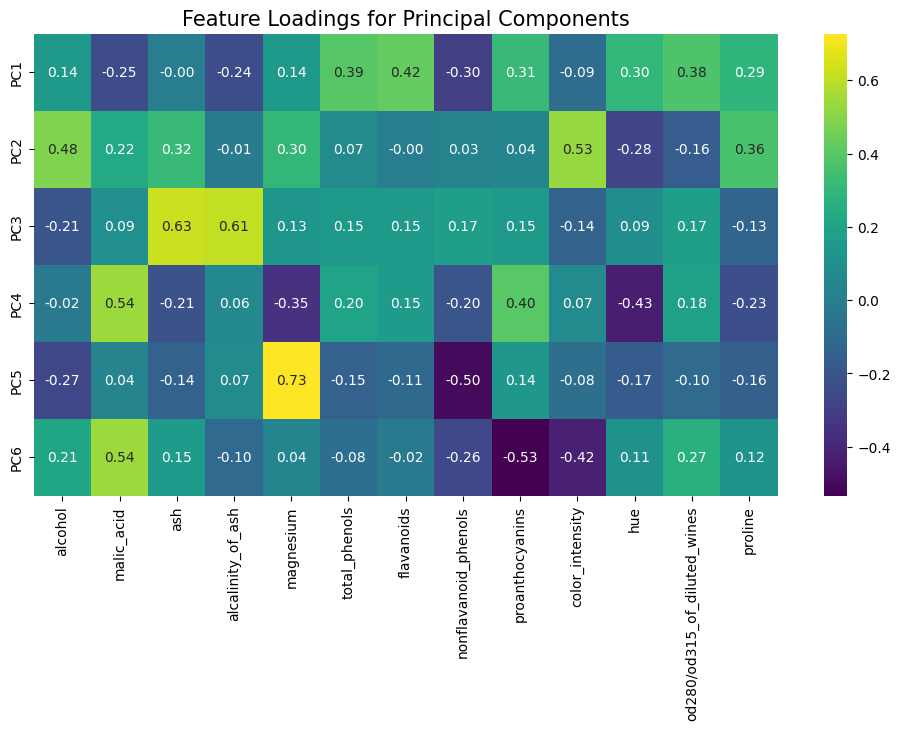

In [ ]:
components_df = pd.DataFrame(pca.components_, columns=feature_names, index=['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6'])

plt.figure(figsize=(12, 6))
sns.heatmap(components_df, annot=True, cmap='viridis', fmt='.2f')
plt.title('Feature Loadings for Principal Components', fontsize=15)
plt.show()

## K-means 클러스터링과 덴드로그램을 통한 클러스터링

In [ ]:
# 와인 데이터셋 준비
wine = datasets.load_wine()
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target

wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [ ]:
from sklearn.preprocessing import StandardScaler

X = wine_df.drop('target', axis=1)
# 데이터 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_features, columns = wine.feature_names)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(scaled_df)
wine_df['kmeans_cluster'] = kmeans_labels

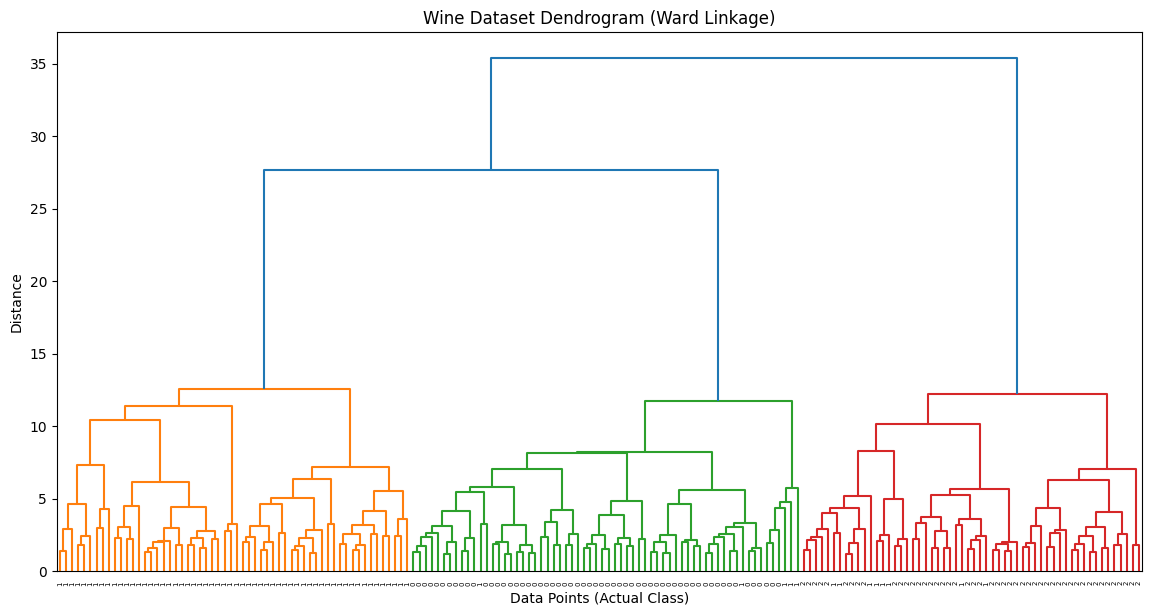

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(scaled_df, method='ward')

plt.figure(figsize=(14, 7))
dendrogram(linked,
           orientation='top',
           labels=wine_df['target'].values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Wine Dataset Dendrogram (Ward Linkage)')
plt.xlabel('Data Points (Actual Class)')
plt.ylabel('Distance')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# 덴드로그램을 통해 3개의 클러스터가 적절해 보임을 확인 후, 클러스터링 수행
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg_cluster.fit_predict(scaled_df)
wine_df['agg_cluster'] = agg_labels

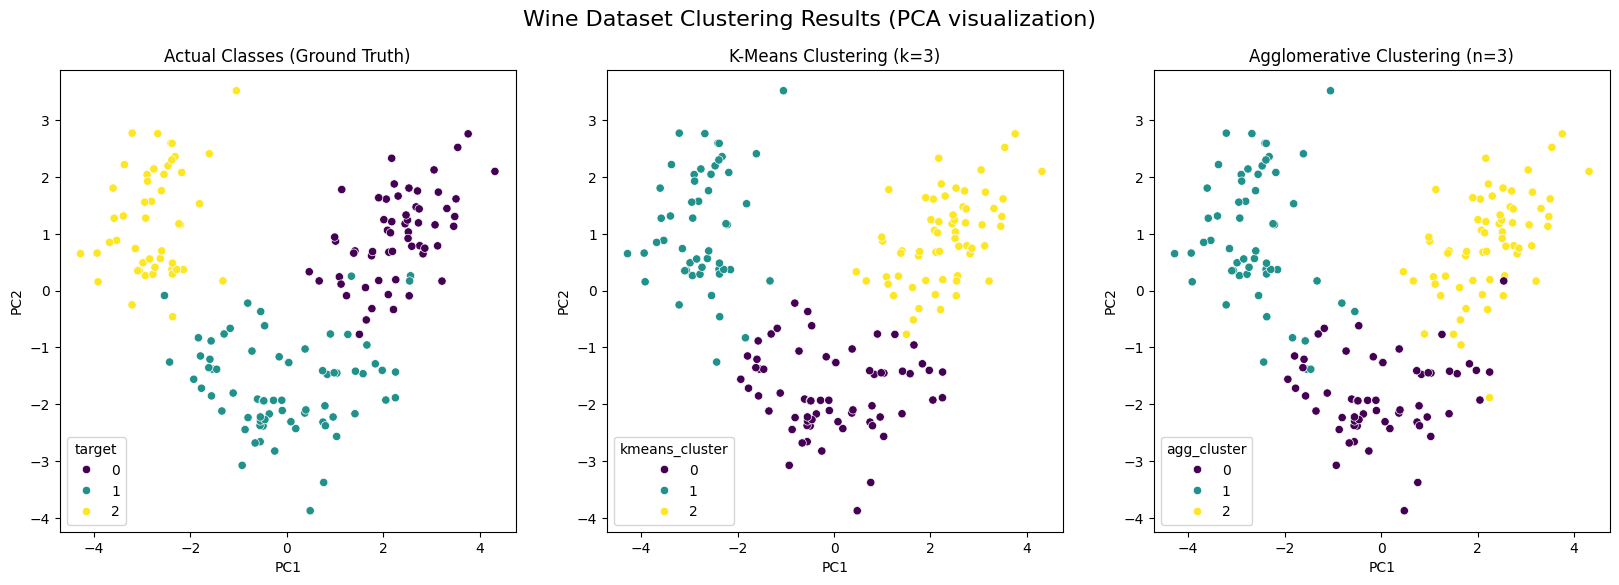

In [ ]:
from sklearn.decomposition import PCA

# 시각화를 위한 차원축소
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])

pca_df['target'] = wine_df['target']
pca_df['kmeans_cluster'] = wine_df['kmeans_cluster']
pca_df['agg_cluster'] = wine_df['agg_cluster']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Wine Dataset Clustering Results (PCA visualization)', fontsize=16)

# 1. 실제 데이터 (Ground Truth)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', palette='viridis', ax=axes[0])
axes[0].set_title('Actual Classes (Ground Truth)')

# 2. K-Means 클러스터링 결과
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='viridis', ax=axes[1])
axes[1].set_title('K-Means Clustering (k=3)')

# 3. 계층적 클러스터링 결과
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='agg_cluster', palette='viridis', ax=axes[2])
axes[2].set_title('Agglomerative Clustering (n=3)')

plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Adjusted Rand Index (ARI): 실제 값과 클러스터링 결과의 유사도. 1에 가까울수록 좋음.
ari_kmeans = adjusted_rand_score(wine_df['target'], wine_df['kmeans_cluster'])
ari_agg = adjusted_rand_score(wine_df['target'], wine_df['agg_cluster'])

# Silhouette Score: 클러스터 내부의 데이터가 얼마나 잘 뭉쳐있는지. 1에 가까울수록 좋음.
sil_kmeans = silhouette_score(scaled_df, wine_df['kmeans_cluster'])
sil_agg = silhouette_score(scaled_df, wine_df['agg_cluster'])

print("\n### 4. 정량적 성능 평가 ###")
print(f"K-Means Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print(f"Agglomerative Clustering ARI: {ari_agg:.4f}")
print("-" * 30)
print(f"K-Means Silhouette Score: {sil_kmeans:.4f}")
print(f"Agglomerative Clustering Silhouette Score: {sil_agg:.4f}")


### 4. 정량적 성능 평가 ###
K-Means Adjusted Rand Index (ARI): 0.8975
Agglomerative Clustering ARI: 0.7899
------------------------------
K-Means Silhouette Score: 0.2849
Agglomerative Clustering Silhouette Score: 0.2774


## 분류 모델 학습과 모델 성능 측정

In [ ]:
# 데이터셋 준비
from sklearn.model_selection import train_test_split

cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 로지스틱 회귀 모형

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
# 모델이 예측한 양성(1)인 확률 출력
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

print(f'정확도: {acc:.4f}')

정확도: 0.9825


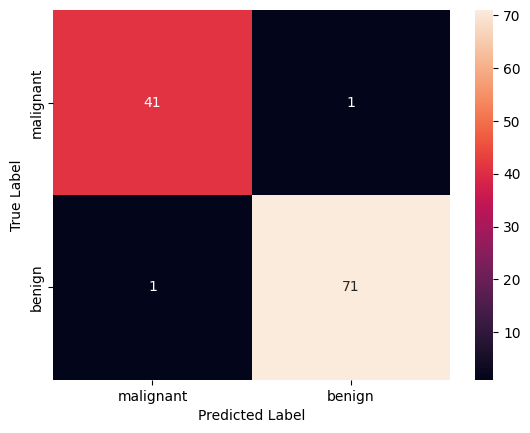

In [ ]:
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

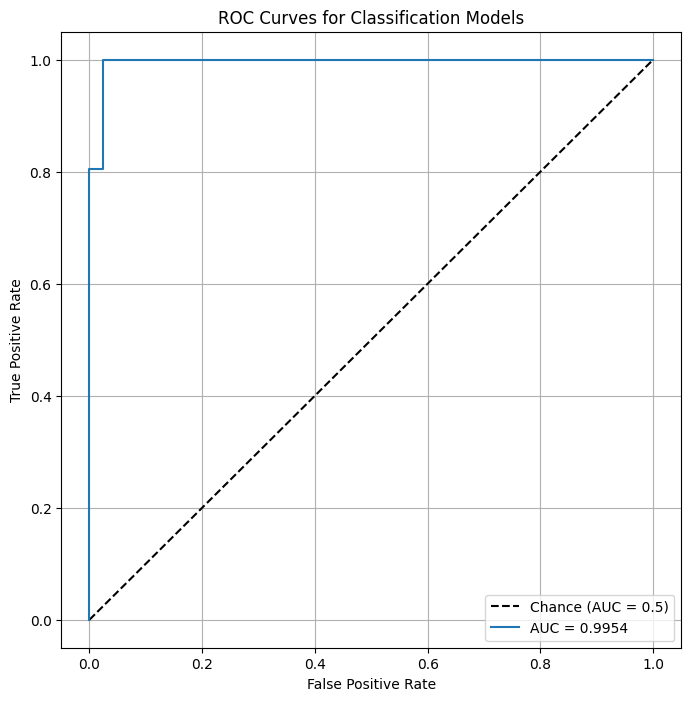

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 결정트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred = dt_model.predict(X_test_scaled)
# 모델이 예측한 양성(1)인 확률 출력
y_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

print(f'정확도: {acc:.4f}')

정확도: 0.9123


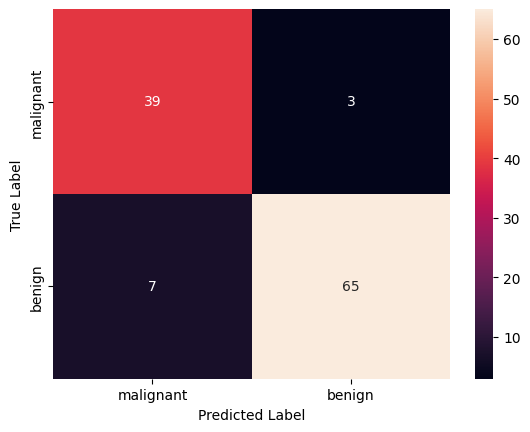

In [ ]:
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

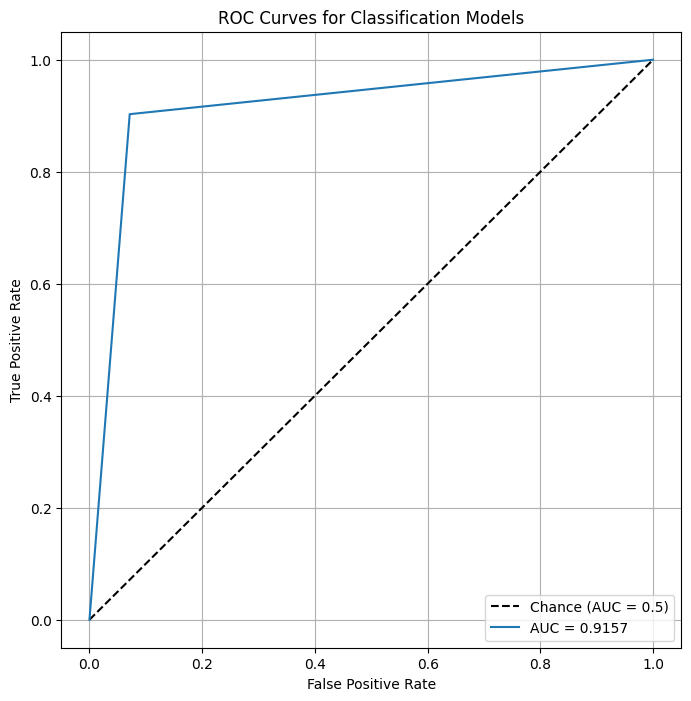

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)
# 모델이 예측한 양성(1)인 확률 출력
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

print(f'정확도: {acc:.4f}')

정확도: 0.9561


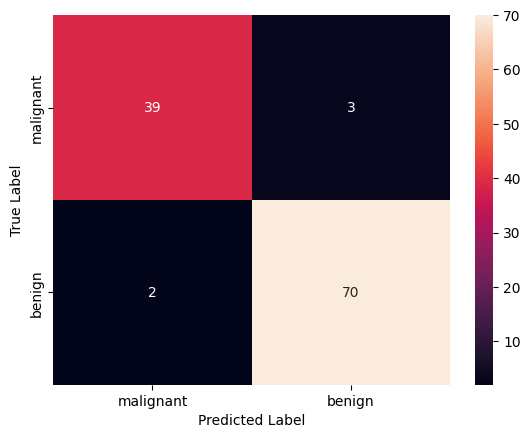

In [ ]:
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

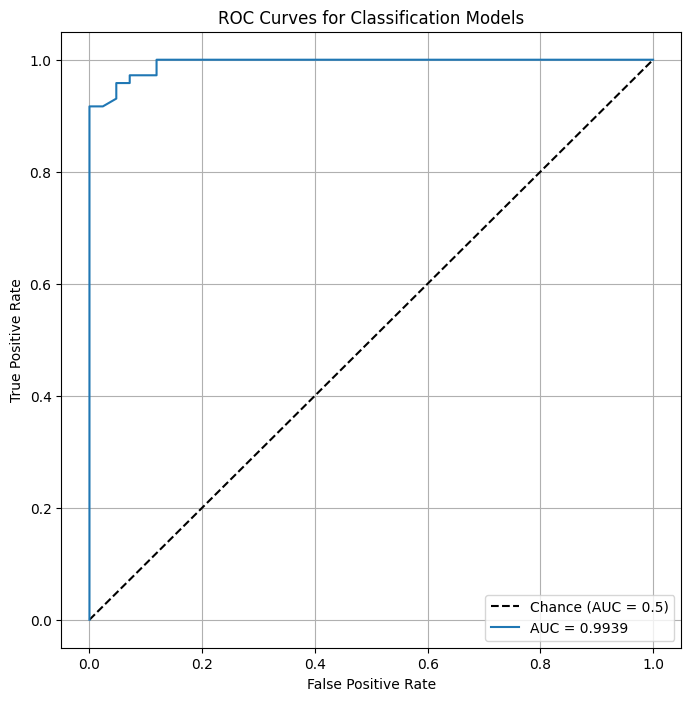

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
# 모델이 예측한 양성(1)인 확률 출력
y_pred_proba = svc.predict_proba(X_test_scaled)[:, 1]

In [ ]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

print(f'정확도: {acc:.4f}')

정확도: 0.9825


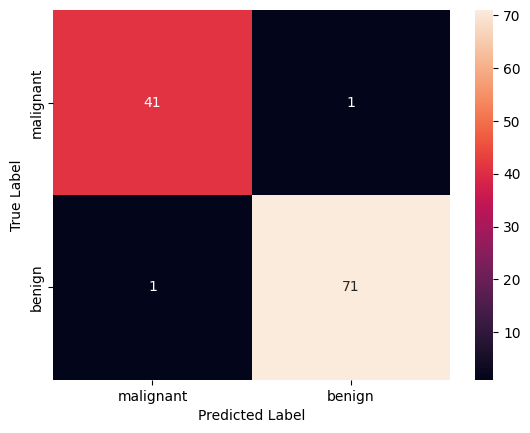

In [ ]:
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

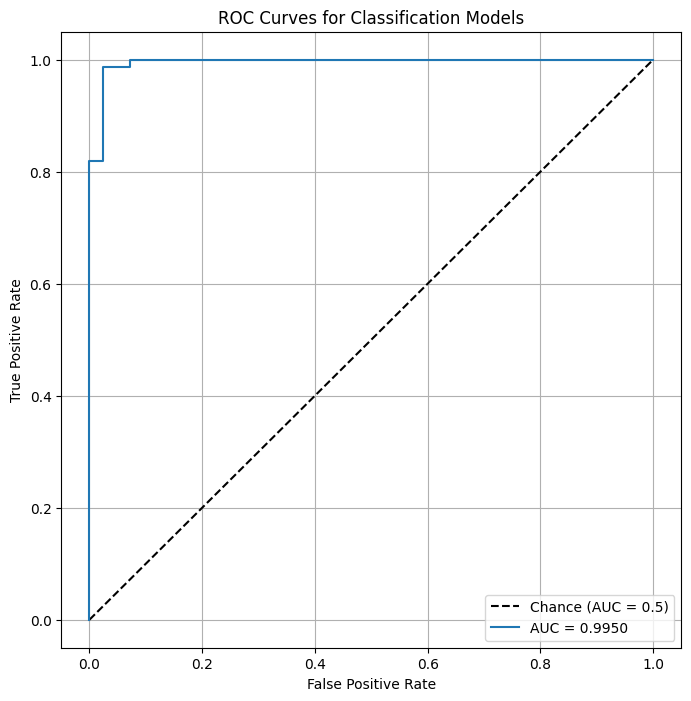

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

--- Logistic Regression ---
정확도: 0.9825
AUC: 0.9954

--- Decision Tree ---
정확도: 0.9123
AUC: 0.9157

--- Random Forest ---
정확도: 0.9561
AUC: 0.9939

--- SVM ---
정확도: 0.9825
AUC: 0.9950



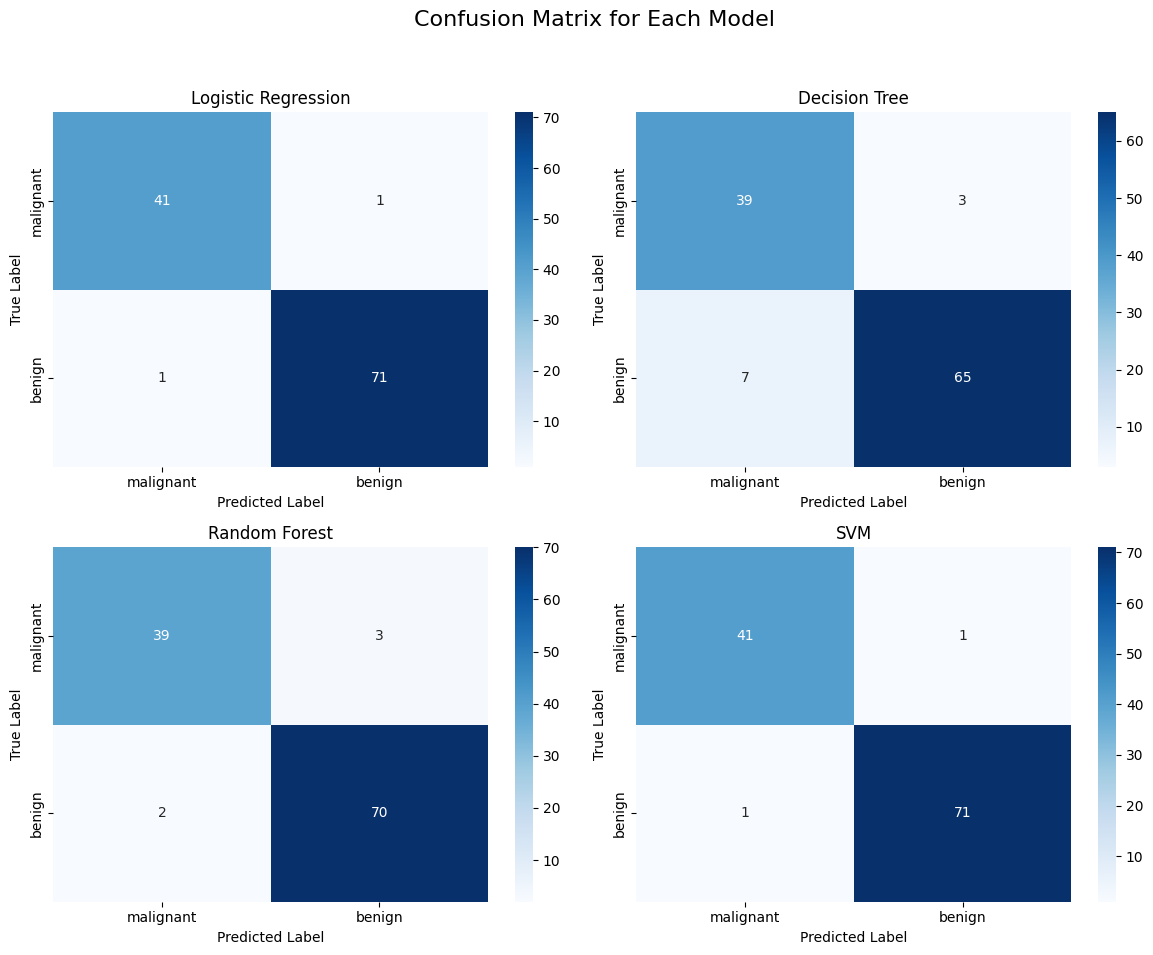

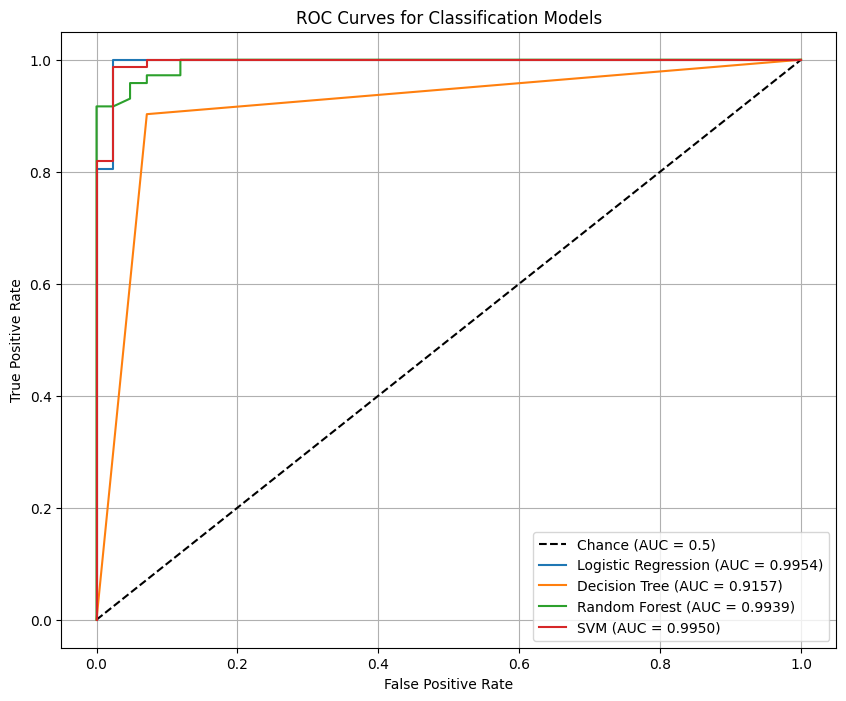

In [ ]:
# 여러가지 모델을 한 번에 비교하기
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42) # ROC-AUC를 위해 probability=True 설정
}

# 결과를 저장할 딕셔너리
results = {}

for name, model in models.items():
    # 모델 학습
    model.fit(X_train_scaled, y_train)

    # 예측 (레이블 및 확률)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # 결과 저장
    results[name] = {'accuracy': accuracy, 'cm': cm, 'auc': auc, 'fpr': fpr, 'tpr': tpr}
    print(f"--- {name} ---")
    print(f"정확도: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}\n")


# ---  결과 시각화 ---

# 혼동 행렬(Confusion Matrix) 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrix for Each Model', fontsize=16)

for i, (name, result) in enumerate(results.items()):
    ax = axes[i//2, i%2]
    sns.heatmap(result['cm'], annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=cancer.target_names, yticklabels=cancer.target_names)
    ax.set_title(name)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ROC 곡선 시각화
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)') # 기준선

for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{name} (AUC = {result['auc']:.4f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 회귀 모델 학습과 모델 성능 측정

In [ ]:
# 데이터셋 준비
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print("### 학습된 회귀 계수 (Coefficients) ###")
print(pd.Series(model.coef_, index=X.columns))
print(f"\n절편 (Intercept): {model.intercept_:.4f}")

### 학습된 회귀 계수 (Coefficients) ###
MedInc        0.448675
HouseAge      0.009724
AveRooms     -0.123323
AveBedrms     0.783145
Population   -0.000002
AveOccup     -0.003526
Latitude     -0.419792
Longitude    -0.433708
dtype: float64

절편 (Intercept): -37.0233


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MSE (Mean Squared Error, 평균 제곱 오차)
mse = mean_squared_error(y_test, y_pred)
print(f"1. Mean Squared Error (MSE): {mse:.4f}")

# RMSE (Root Mean Squared Error, 평균 제곱근 오차)
rmse = np.sqrt(mse)
# 또는 rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"2. Root Mean Squared Error (RMSE): {rmse:.4f}")

# MAE (Mean Absolute Error, 평균 절대 오차)
mae = mean_absolute_error(y_test, y_pred)
print(f"3. Mean Absolute Error (MAE): {mae:.4f}")

# R-squared (결정 계수)
r2 = r2_score(y_test, y_pred)
print(f"4. R-squared (결정 계수): {r2:.4f}")

1. Mean Squared Error (MSE): 0.5559
2. Root Mean Squared Error (RMSE): 0.7456
3. Mean Absolute Error (MAE): 0.5332
4. R-squared (결정 계수): 0.5758
